## Citation and Dataset Attribution
This project is based on the following research paper:

Cilia, N. D., De Gregorio, G., De Stefano, C., Fontanella, F., Marcelli, A., & Parziale, A. (2022). Diagnosing Alzheimer’s disease from on-line handwriting: A novel dataset and performance benchmarking. Engineering Applications of Artificial Intelligence, 111, 104822. https://doi.org/10.1016/j.engappai.2022.104822

The DARWIN dataset used in this project was introduced in the above study. It includes handwriting data from 174 participants and was created to support early Alzheimer's diagnosis through handwriting dynamics analysis.

If you reuse or build upon this work, please cite the original authors.

## Project Overview

This project explores the DARWIN dataset, a unique collection of handwriting tasks specifically designed to assess motor and cognitive functions associated with Alzheimer's Disease (AD). The dataset includes 25 distinct tasks, each capturing a variety of temporal and kinematic features such as total time, mean pressure, and air time.

For this analysis, I selected a subset of nine tasks based on their strong average performance and low standard deviation across multiple machine learning models, as reported in Table 7 of the original DARWIN paper:

`selected_tasks = ['5', '6', '7', '15', '16', '17', '19', '23', '24']`

The primary goals of this study are to:

- Evaluate the performance of machine learning models, specifically Logistic Regression, Random Forest, and Support Vector Machine (SVM), on the selected subset of tasks.

- Assess each model using three key metrics: Accuracy, AD Recall, and AD F1 Score.

**Why These Metrics?**

In a sensitive medical classification task like Alzheimer’s detection, each metric offers distinct insights:

**Accuracy**
Reflects overall correctness of predictions. While useful as a general indicator, accuracy alone can be misleading when dealing with imbalanced classes (ex: fewer AD cases).

**AD Recall (Sensitivity)**
Measures how well the model identifies actual AD cases. High recall reduces false negatives, which is critical in medical settings where missing a diagnosis can delay intervention and care.

**AD F1 Score**
Combines both precision and recall into a single score.. A high F1 score for the AD class suggests the model effectively balances catching true cases (recall) while minimizing false alarms (precision).

This analysis aims to determine which model offers the best balance of performance and clinical reliability when classifying Alzheimer's Disease based on handwriting task data.

In [392]:
import os
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import sklearn
import xgboost as xgb 
import shap

zip_path = '/Users/daishadrayton/Desktop/darwin.zip'

extract_folder = '/Users/daishadrayton/Desktop/darwin_data'

os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

csv_path = os.path.join(extract_folder, 'data.csv')
df = pd.read_csv(csv_path)

print(df.head())
print(df.info())

     ID  air_time1  disp_index1  gmrt_in_air1  gmrt_on_paper1  \
0  id_1       5160     0.000013    120.804174       86.853334   
1  id_2      51980     0.000016    115.318238       83.448681   
2  id_3       2600     0.000010    229.933997      172.761858   
3  id_4       2130     0.000010    369.403342      183.193104   
4  id_5       2310     0.000007    257.997131      111.275889   

   max_x_extension1  max_y_extension1  mean_acc_in_air1  mean_acc_on_paper1  \
0               957              6601          0.361800            0.217459   
1              1694              6998          0.272513            0.144880   
2              2333              5802          0.387020            0.181342   
3              1756              8159          0.556879            0.164502   
4               987              4732          0.266077            0.145104   

   mean_gmrt1  ...  mean_jerk_in_air25  mean_jerk_on_paper25  \
0  103.828754  ...            0.141434              0.024471   
1   99

In [393]:
from sklearn.model_selection import train_test_split

# Tasks I chose to keep
selected_tasks = ['5', '6', '7', '15', '16', '17', '19', '24']

# Columns to always keep
keep_cols = ['ID', 'class']

# Start with an empty list of columns to keep
columns_to_keep = []

# This loop checks every column name in the dataset and keeps it if it ends with one of the selected task numbers.
for col in df.columns:
    if col.endswith(tuple(selected_tasks)):
        columns_to_keep.append(col)

# Also keep ID and class
columns_to_keep += keep_cols

# Create a filtered df
df_filtered = df[columns_to_keep]

# Define X and y
X = df_filtered.drop(columns=['ID', 'class'])  # features only
y = df_filtered['class'].map({'H': 0, 'P': 1})  # convert class to 0/1

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22, stratify=y
)

## Class Balance

I explored the class balance of the training set using a bar chart, which showed the classes are evenly distributed.

Imbalanced classes can bias a model toward the majority class, so it's important to catch this early and adjust evaluation methods or training strategies accordingly. In this case, the classes are well balanced (approximately 51% vs. 49%), so no special balancing techniques are needed before training.

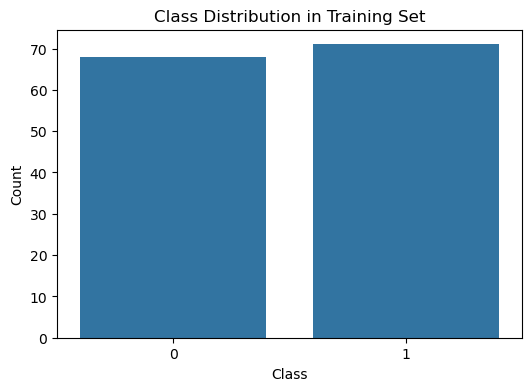

In [394]:
# Check class balance with bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [395]:
# Check percentages
y_train.value_counts(normalize=True)

class
1    0.510791
0    0.489209
Name: proportion, dtype: float64

### Heatmap

This heatmap visualizes the Pearson correlation coefficients between features, serving as a tool for understanding relationships and potential redundancies in the dataset crucial for machine learning model building. Key observations include a few high positive correlations, such as `total_time19` and `air_time19` at 1.000. These indicate highly redundant features that can cause multicollinearity, which might impact model interpretability or inflate feature importance in linear models like Logistic Regression. While Random Forest is generally more tolerant of such correlated features, identifying these relationships is still important. 

Even though the primary focus of this project is on achieving high accuracy and F1 scores, understanding multicollinearity matters because it can affect model stability, training efficiency, and generalizability, indirectly influencing those final performance metrics. A cleaner feature set, guided by insights from this heatmap, can lead to a more streamlined and potentially more robust model in real-world deployment, contributing to the ultimate goal of reliable AD prediction. 

However, for this specific project, while recognizing the potential for further feature refinement, the decision was made to keep all features from the chosen tasks inclusive, believing that every extracted feature for each task contributes meaningfully to the overall signal for AD detection. 

Overall, this heatmap offers a valuable visual summary for guiding feature selection decisions and building a more efficient and reliable model for Alzheimer's prediction by identifying redundant or independent features.

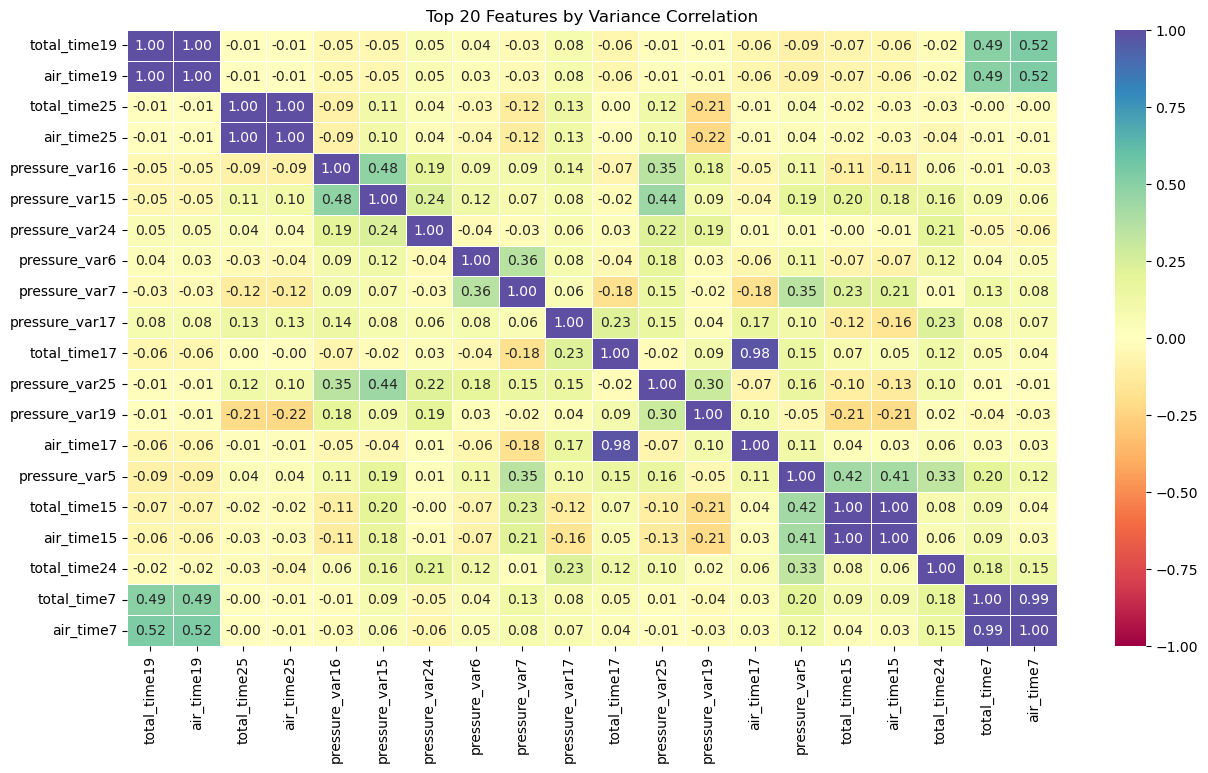

In [415]:
# Use Variance to narrow down the features
variances = X_train.var().sort_values(ascending=False).head(20).index
subset_corr = X_train[variances].corr()

plt.figure(figsize=(15, 8))
sns.heatmap(subset_corr,
            annot=True,
            cmap='Spectral',
            linewidths=0.5,
            fmt=".2f",
            vmin=-1,  # Set the minimum value for the colormap
            vmax=1)   # Set the maximum value for the colormap
plt.title('Top 20 Features by Variance Correlation')
plt.show()

## Added Feature

Task 23 was added to represent a diverse range of cognitive task types (G = gross motor, C = coordination, M = memory). Although it's the only M-type feature, it was retained to increase domain diversity in the feature set. Future work may explore additional memory tasks for balance.

In [397]:
# Add a memory task  to represent each category (M, G, C)
selected_tasks = ['5', '6', '7', '15', '16', '17', '19', '23', '24']

## Train/Val/Test Sets

In [398]:
# Split full dataset: train+val (80%) and test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=22)

# Then split the 80% into train and val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=22)

In [399]:
# Re-run code with updated features

# Columns to always keep
keep_cols = ['ID', 'class']

# Start with an empty list of columns to keep
columns_to_keep = []

# Loop over every column name in the df
for col in df.columns:
    if col.endswith(tuple(selected_tasks)):
        columns_to_keep.append(col)

# Also keep ID and class
columns_to_keep += keep_cols

# Filtered DataFrame
df_filtered = df[columns_to_keep]

# Define X and y
X = df_filtered.drop(columns=['ID', 'class'])
y = df_filtered['class'].map({'H': 0, 'P': 1})

## Class Balance Check (After Adding New Feature)

After adding a new task feature (task 23, representing the memory domain), I checked the class distribution again. The class balance remained the same:

Class 1 (Alzheimer’s): ~51%

Class 0 (Healthy): ~49%

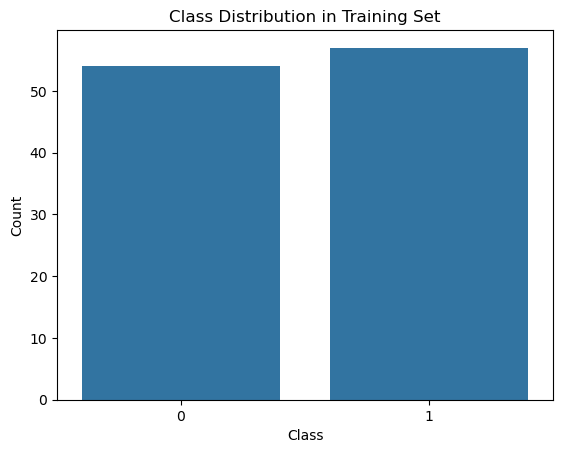

In [400]:
# Check class balance with bar plot

# Plot class distribution
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [401]:
# Check percentages
y_train.value_counts(normalize=True)

class
1    0.513514
0    0.486486
Name: proportion, dtype: float64

## Preprocessing the data

- Missing Values
- Outliers
- Feature Engineering
- Data Transformation 

In [402]:
# Check missing values 
print("X_train Info")
X_train.info()

print("\n X_test Info")
X_test.info()

X_train Info
<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, 81 to 31
Columns: 162 entries, air_time5 to total_time25
dtypes: float64(108), int64(54)
memory usage: 141.4 KB

 X_test Info
<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 128 to 79
Columns: 162 entries, air_time5 to total_time25
dtypes: float64(108), int64(54)
memory usage: 44.6 KB


In [403]:
# Check stats 
print(X_train.describe())

          air_time5  disp_index5  gmrt_in_air5  gmrt_on_paper5  \
count    111.000000   111.000000    111.000000      111.000000   
mean    3955.756757     0.000015    120.840397       76.260116   
std     8298.038625     0.000004     71.184455       38.613906   
min       35.000000     0.000000      0.000000        0.000000   
25%      657.500000     0.000014     71.026536       51.230269   
50%     1000.000000     0.000015    101.628410       72.301832   
75%     2815.000000     0.000016    157.887867       87.680975   
max    66034.000000     0.000034    399.868965      267.240495   

       max_x_extension5  max_y_extension5  mean_acc_in_air5  \
count        111.000000        111.000000        111.000000   
mean        2789.756757       2647.468468          0.279167   
std         1119.946315        764.474149          0.205851   
min            0.000000          0.000000          0.089748   
25%         2423.500000       2415.500000          0.186621   
50%         2528.000000    

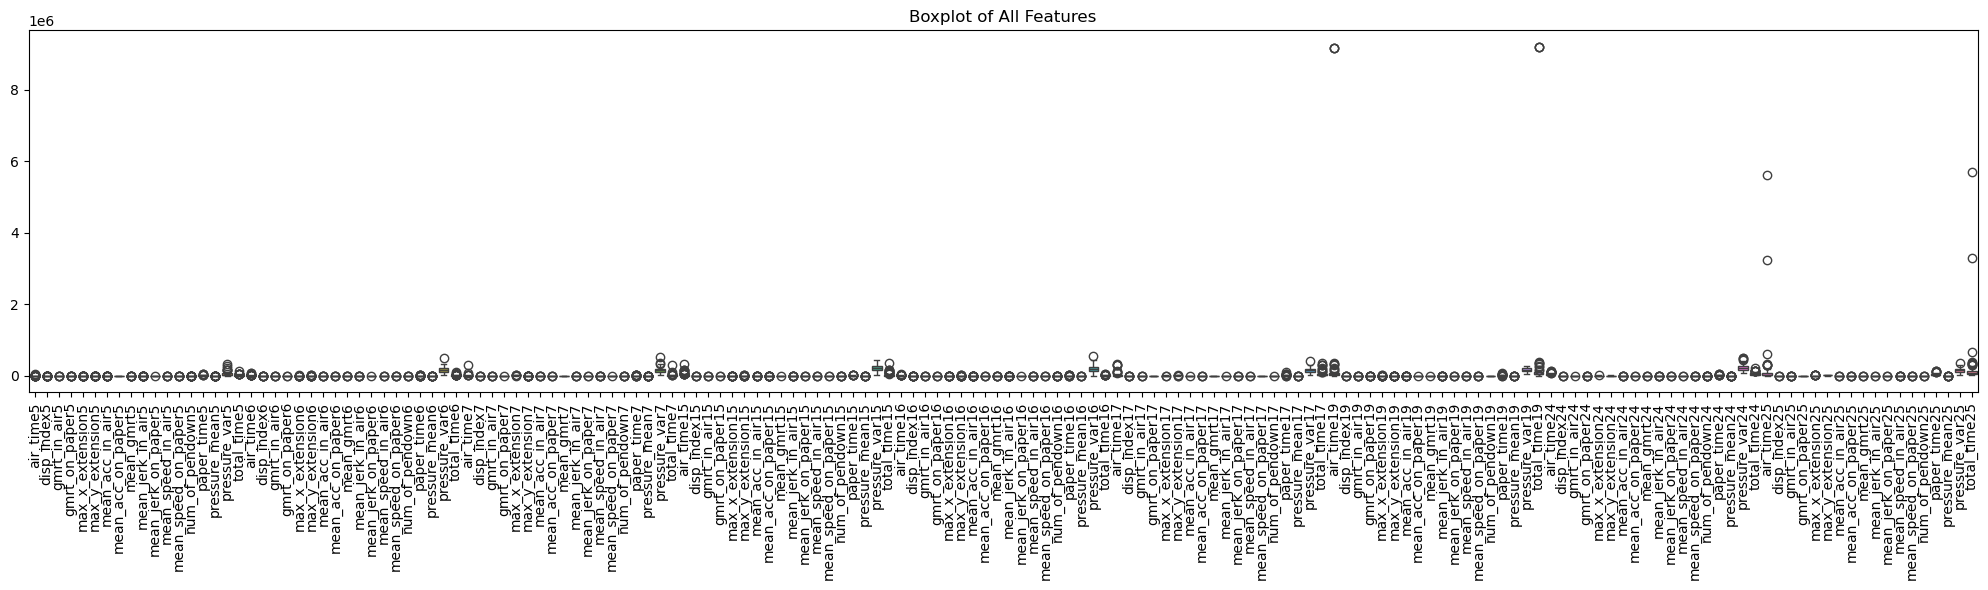

In [404]:
# Boxplot for outliers
plt.figure(figsize=(20, 6))  
sns.boxplot(data=X_train)
plt.xticks(rotation=90)  
plt.title("Boxplot of All Features")
plt.tight_layout()
plt.show()

## Outliers

There are 6 outliers, 2 of them being extreme. The outliers are okay for now because I will start off building a RF model, which can handle outliers. 

## Baseline Model – Dummy Classifier

Before evaluating real models, I established a baseline using a `DummyClassifier`. This model doesn't learn from the data, it simply predicts the most frequent class, giving us a minimum performance threshold.

**Why this matters**: If a trained model can’t outperform a dummy classifier, it’s not learning meaningful patterns.

**Dummy Strategy Used**: `most_frequent` (always predicts the majority class)

This provides context for why the models that follow are meaningful.


In [405]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Initialize dummy classifier
dummy = DummyClassifier(strategy="most_frequent")  
dummy.fit(X_train, y_train)

# Predict on validation set
y_pred_dummy = dummy.predict(X_val)

# Evaluate
print(classification_report(y_val, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.50      1.00      0.67        14

    accuracy                           0.50        28
   macro avg       0.25      0.50      0.33        28
weighted avg       0.25      0.50      0.33        28



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Baseline Dummy

**Purpose**: Before training more complex models, it's important to establish a simple baseline to ensure the models are providing meaningful improvements instead of random chance or naive predictions.

**Strategy**:`most_frequent` was used, which simply predicts the most prevalent class in the training data.

As observed, the dummy classifier achieved an **accuracy of 50%**. This 50% accuracy serves as a benchmark: any effective model must perform significantly better than this simple baseline.

## Scale features 

In [330]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

# Fit scaler on training data and transform it 
X_train_scaled = scaler.fit_transform(X_train)

# Check scaled features
print(X_train_scaled) 

[[-0.31362909 -0.28540692 -0.46879663 ...  0.92349262 -1.12727078
  -0.21672759]
 [-0.12962254  0.14165109 -1.03370226 ...  0.6230191  -0.64314798
  -0.21138786]
 [-0.36689414  0.09140897 -0.19946603 ...  0.92349262 -1.12727078
  -0.21672759]
 ...
 [-0.38565797 -0.73758598 -0.3196063  ...  0.74131128 -0.17203015
   0.25956799]
 [-0.32149779  0.16677215 -0.96889609 ...  1.01484686 -1.29526738
  -0.21159982]
 [-0.2894177   0.3174985  -0.744701   ...  0.1260537   2.26921727
   0.20019511]]


In [331]:
# Transform validation and test sets using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression Model 

In [332]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

# Train Logistic Regression Model 
lr_model.fit(X_train_scaled, y_train)

# Make predicton
y_val_pred_lr = lr_model.predict(X_val_scaled)

In [389]:
# Evaluate
val_accuracy_lr = accuracy_score(y_val, y_val_pred_lr)
val_classification_report_lr = classification_report(y_val, y_val_pred_lr, output_dict=True)  
val_confusion_matrix_lr = confusion_matrix(y_val, y_val_pred_lr)

# Store performance metrics in a dictionary
performance = {
    'Validation Accuracy': [val_accuracy_lr],
    'Confusion Matrix': [val_confusion_matrix_lr]
}
performance_df = pd.DataFrame(performance)

print("Validation Accuracy (LR):", val_accuracy_lr)
print("\nConfusion Matrix (LR):\n", val_confusion_matrix_lr)

report_df = pd.DataFrame(val_classification_report_lr).transpose()
print("\nLogistic Regression Report (LR):\n", report_df)

Validation Accuracy (LR): 0.8214285714285714

Confusion Matrix (LR):
 [[13  1]
 [ 4 10]]

Logistic Regression Report (LR):
               precision    recall  f1-score    support
0              0.764706  0.928571  0.838710  14.000000
1              0.909091  0.714286  0.800000  14.000000
accuracy       0.821429  0.821429  0.821429   0.821429
macro avg      0.836898  0.821429  0.819355  28.000000
weighted avg   0.836898  0.821429  0.819355  28.000000


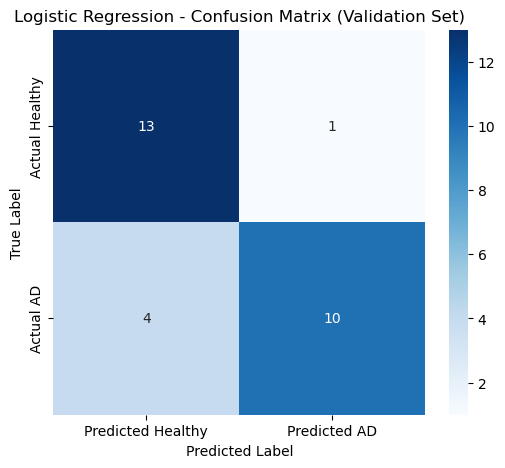

In [391]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(val_confusion_matrix_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Healthy', 'Predicted AD'], 
            yticklabels=['Actual Healthy', 'Actual AD'])
plt.title('Logistic Regression - Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Logistic Regression – Validation Performance Summary

The Logistic Regression model achieved a validation accuracy of **82.1%**, significantly outperforming the dummy classifier baseline of 50%. It demonstrated good performance overall, with particularly high precision for Alzheimer’s cases (0.91) and recall for healthy individuals (0.93).

However, the confusion matrix reveals 1 false positive and 4 false negatives, suggesting the model tends to miss some true AD cases. This is a critical limitation in a medical context where early and accurate detection is essential.

The F1 scores were 0.84 for Healthy and 0.80 for AD, indicating a fairly balanced model but this could still be improved, especially in reducing false negatives. Given the stakes of Alzheimer’s detection, enhancing recall for the AD class should be a priority in future iterations.

## Building Random Forest Model

In [335]:
# Random Forest with train+val sets
rf_model = RandomForestClassifier(
    n_estimators = 100,
    max_depth = None,
    random_state = 42,
    class_weight = 'balanced'
)

# Fit on training set
rf_model.fit(X_train, y_train)

# Predict on validation set
y_val_predict = rf_model.predict(X_val)

In [406]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

val_accuracy = accuracy_score(y_val, y_val_predict)
val_classification_report = classification_report(y_val, y_val_predict, output_dict=True) 
val_confusion_matrix = confusion_matrix(y_val, y_val_predict)

performance = {
    'Validation Accuracy': [val_accuracy],
    'Confusion Matrix': [val_confusion_matrix]
}

performance_df = pd.DataFrame(performance)

print("Validation Accuracy (RF):", val_accuracy)
print("\nConfusion Matrix (RF):\n", val_confusion_matrix)

report_df = pd.DataFrame(val_classification_report).transpose()
print("\nClassification Report (RF):\n", report_df)

Validation Accuracy (RF): 0.7857142857142857

Confusion Matrix (RF):
 [[11  3]
 [ 3 11]]

Classification Report (RF):
               precision    recall  f1-score    support
0              0.785714  0.785714  0.785714  14.000000
1              0.785714  0.785714  0.785714  14.000000
accuracy       0.785714  0.785714  0.785714   0.785714
macro avg      0.785714  0.785714  0.785714  28.000000
weighted avg   0.785714  0.785714  0.785714  28.000000


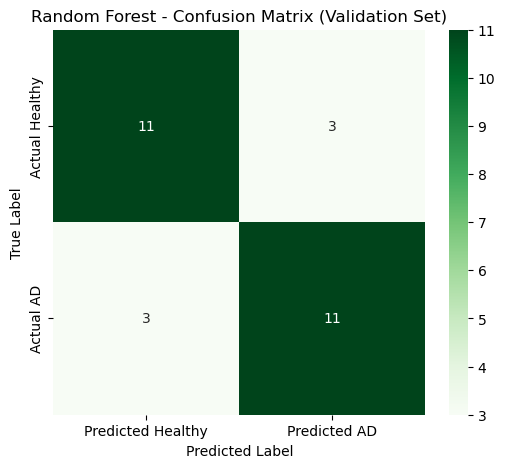

In [387]:
# Heatmap of confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(val_confusion_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Healthy', 'Predicted AD'],
            yticklabels=['Actual Healthy', 'Actual AD'])
plt.title('Random Forest - Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Random Forest (RF) – Validation Performance Summary

The Random Forest classifier achieved a validation accuracy of **78.6%**, performing equally well across both classes. Precision, recall, and F1 scores were balanced at 0.79 for both Alzheimer’s (1) and Healthy (0) groups, suggesting consistent decision-making.

The confusion matrix shows 3 false negatives and 3 false positives, indicating a moderate level of error but no strong bias toward either class. Overall, this model outperformed the dummy baseline (50% accuracy), but so far did not outperform LR.

## Next Step: SVM

In [408]:
from sklearn.svm import SVC

# Initialize SVM model 
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

# Train on scaled training data
svm_model.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred_svm = svm_model.predict(X_val_scaled)

In [409]:
val_accuracy_svm = accuracy_score(y_val, y_val_pred_svm)
val_confusion_matrix_svm = confusion_matrix(y_val, y_val_pred_svm)
val_classification_report_svm = classification_report(y_val, y_val_pred_svm, output_dict=True)

svm_performance = {
    'Validation Accuracy': [val_accuracy_svm],
    'Confusion Matrix': [val_confusion_matrix_svm]
}
svm_performance_df = pd.DataFrame(svm_performance)

print("Validation Accuracy (SVM):", val_accuracy_svm)
print("\nConfusion Matrix (SVM):\n", val_confusion_matrix_svm)

svm_report_df = pd.DataFrame(val_classification_report_svm).transpose()
print("\nSVM Classification Report:\n", svm_report_df)

Validation Accuracy (SVM): 0.8571428571428571

Confusion Matrix (SVM):
 [[12  2]
 [ 2 12]]

SVM Classification Report:
               precision    recall  f1-score    support
0              0.857143  0.857143  0.857143  14.000000
1              0.857143  0.857143  0.857143  14.000000
accuracy       0.857143  0.857143  0.857143   0.857143
macro avg      0.857143  0.857143  0.857143  28.000000
weighted avg   0.857143  0.857143  0.857143  28.000000


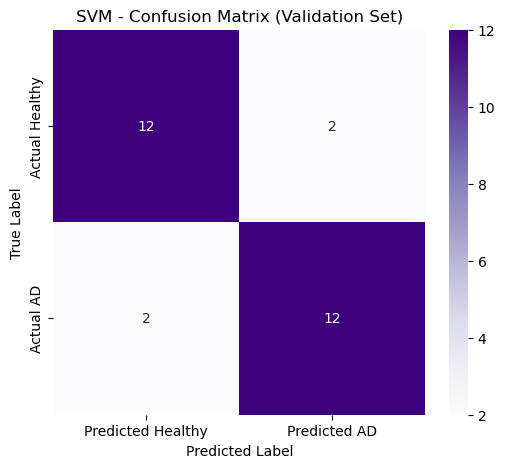

In [385]:
# Heatmap of SVM confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(val_confusion_matrix_svm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Predicted Healthy', 'Predicted AD'],
            yticklabels=['Actual Healthy', 'Actual AD'])
plt.title('SVM - Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Support Vector Machine (SVM) – Validation Performance Summary

The Support Vector Machine classifier achieved a validation accuracy of **85.7%**, making it the top-performing model so far without tuning. It demonstrated perfectly balanced performance across both classes, with precision, recall, and F1 scores of 0.86 for both Alzheimer’s (1) and Healthy (0) participants.

The confusion matrix reveals only 2 false negatives and 2 false positives, indicating strong reliability with minimal classification error. This performance significantly surpasses the dummy baseline and highlights the SVM's effectiveness at separating the two groups based on handwriting features.

## Let's optimize our parameters.

Our objective is to maximize accuracy while also achieving strong recall and F1 scores.

In [341]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

# Scoring dictionary
scoring = {
    'accuracy': 'accuracy',
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# GridSearchCV with multi-metric scoring
grid_rf = GridSearchCV(
    rf_model,
    param_grid,
    scoring=scoring,
    refit='f1',  # Refit the best model based on F1 score
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit
grid_rf.fit(X_train, y_train)

# Results
print("Best params (based on F1):", grid_rf.best_params_)
print("Best F1 score:", grid_rf.best_score_)

best_rf_f1 = grid_rf.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params (based on F1): {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best F1 score: 0.841750705434916


In [342]:
# Predict using the best RF model for F1
y_val_pred_rf_f1 = best_rf_f1.predict(X_val)

# Evaluate
acc = accuracy_score(y_val, y_val_pred_rf_f1)
recall = recall_score(y_val, y_val_pred_rf_f1)
f1 = f1_score(y_val, y_val_pred_rf_f1)
cm = confusion_matrix(y_val, y_val_pred_rf_f1)
report = classification_report(y_val, y_val_pred_rf_f1, output_dict=True)

print("Fine-Tuned RF (F1) on Validation Set")
print("Accuracy:", acc)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)

Fine-Tuned RF (F1) on Validation Set
Accuracy: 0.8214285714285714
Recall: 0.7857142857142857
F1 Score: 0.8148148148148148
Confusion Matrix:
 [[12  2]
 [ 3 11]]


## Fine-Tuned RF Summary 

After tuning the Random Forest classifier using a grid search with 5-fold cross-validation, the model achieved a validation accuracy of **82.1%** and an AD F1 score of **81.5%**, improving over the untuned version which had a flat 78.6% across all metrics. While the recall for Alzheimer’s cases remained the same at 78.6%, the fine-tuned model showed greater precision and a stronger F1 score, indicating better balance between sensitivity and accuracy. This suggests that hyperparameter optimization helped the model generalize better and reduce misclassifications, especially false positives, without compromising its ability to detect AD cases. Given the clinical relevance of early and reliable Alzheimer’s detection, these improvements strengthen the model’s practical value.

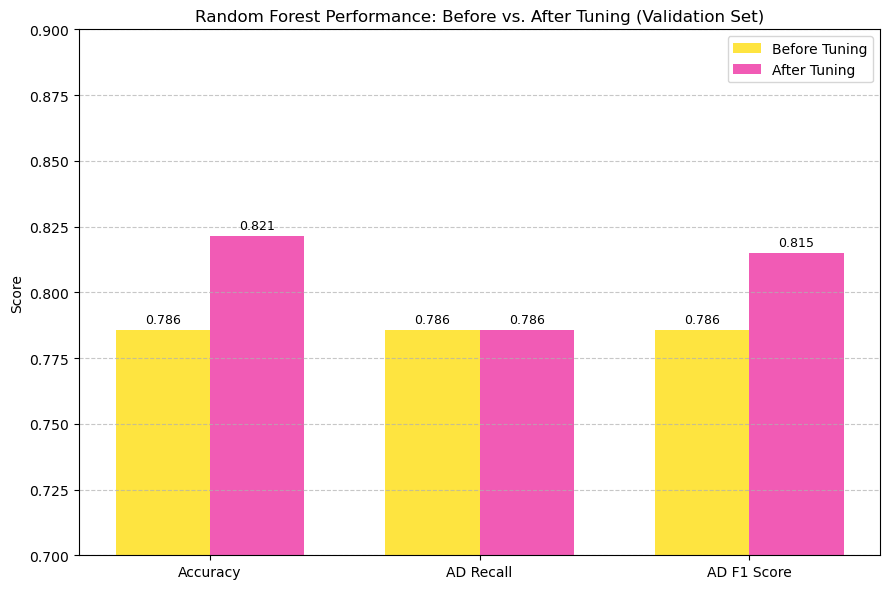

In [410]:
# Metrics to compare
metrics = ['Accuracy', 'AD Recall', 'AD F1 Score']

# Initial (Before Tuning) Random Forest Validation Metrics
initial_rf_acc = 0.785714
initial_rf_recall_ad = 0.785714
initial_rf_f1_ad = 0.785714

# Tuned (After Tuning) Random Forest Validation Metrics
tuned_rf_acc = 0.821428
tuned_rf_recall_ad = 0.785714
tuned_rf_f1_ad = 0.814814

before_tuning = [initial_rf_acc, initial_rf_recall_ad, initial_rf_f1_ad]
after_tuning = [tuned_rf_acc, tuned_rf_recall_ad, tuned_rf_f1_ad]

x = np.arange(len(metrics))  
width = 0.35  

# Create the bar chart
fig, ax = plt.subplots(figsize=(9, 6))
bars1 = ax.bar(x - width/2, before_tuning, width, label='Before Tuning', color='#fee440')
bars2 = ax.bar(x + width/2, after_tuning, width, label='After Tuning', color='#f15bb5')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Random Forest Performance: Before vs. After Tuning (Validation Set)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0.7, 0.9) # Adjust y-limit to better show the differences
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for readability

# Add value labels on top of bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', # Format to 3 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9) 

autolabel(bars1)
autolabel(bars2)

plt.tight_layout() 
plt.show()

## Next - Logistic Regression Hyperparameter Tuning (F1 Score)

In [344]:
# Define parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],  # Use 'liblinear' if using 'l1' in future
    'class_weight': ['balanced', None]
}

# Create F1 scorer (targeting Alzheimer's class: label=1)
f1_scorer_lr = make_scorer(f1_score, pos_label=1)

# Initialize base model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# GridSearchCV for F1-score
grid_lr_f1 = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    scoring=f1_scorer_lr,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid_lr_f1.fit(X_train_scaled, y_train)

# Best estimator + score
print("Best Params (Logistic Regression - F1):", grid_lr_f1.best_params_)
print("Best CV F1 Score:", grid_lr_f1.best_score_)

# Save best model
best_lr_f1 = grid_lr_f1.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params (Logistic Regression - F1): {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1 Score: 0.8534612730264903


In [345]:
# Predict on validation set using the fine-tuned model
y_val_pred_best_lr = best_lr_f1.predict(X_val_scaled)

# Evaluate performance
val_accuracy_best_lr = accuracy_score(y_val, y_val_pred_best_lr)
val_recall_best_lr = recall_score(y_val, y_val_pred_best_lr)
val_f1_best_lr = f1_score(y_val, y_val_pred_best_lr)
val_conf_matrix_best_lr = confusion_matrix(y_val, y_val_pred_best_lr)
val_report_best_lr = classification_report(y_val, y_val_pred_best_lr, output_dict=True)

report_df = pd.DataFrame(val_report_best_lr).transpose()

print("Fine-Tuned Logistic Regression (F1-focused) – Validation Set Results")
print("Accuracy:", val_accuracy_best_lr)
print("Recall:", val_recall_best_lr)
print("F1 Score:", val_f1_best_lr)
print("Confusion Matrix:\n", val_conf_matrix_best_lr)
print("\nClassification Report:\n", report_df)


Fine-Tuned Logistic Regression (F1-focused) – Validation Set Results
Accuracy: 0.8571428571428571
Recall: 0.7857142857142857
F1 Score: 0.8461538461538461
Confusion Matrix:
 [[13  1]
 [ 3 11]]

Classification Report:
               precision    recall  f1-score    support
0              0.812500  0.928571  0.866667  14.000000
1              0.916667  0.785714  0.846154  14.000000
accuracy       0.857143  0.857143  0.857143   0.857143
macro avg      0.864583  0.857143  0.856410  28.000000
weighted avg   0.864583  0.857143  0.856410  28.000000


## Fine-Tuned LR Summary 

After fine-tuning the Logistic Regression model using GridSearchCV to optimize for F1 score, the validation accuracy improved from **82.1%** to **85.7%**. The best-performing configuration used L2 regularization, a lower C value of 0.1, and class balancing to better handle potential class imbalance. Compared to the original model, the fine-tuned version showed gains in both overall accuracy and F1 score (from 0.80 to 0.85 for the Alzheimer’s class), while also reducing false negatives.

## Next - SVM Hyperparameter Tuning (F1 Score)

In [346]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Slightly broader but safe parameter grid
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],            # explore regularization range
    'kernel': ['linear'],       
    'class_weight': ['balanced', None]  # test both class weighting strategies
}

# F1 scorer focused on Alzheimer’s class
f1_scorer = make_scorer(f1_score, pos_label=1)

svm_model = SVC(probability=True, random_state=42)

# Run GridSearchCV with careful limits
grid_svm_f1 = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_svm,
    scoring=f1_scorer,
    cv=3,         # use 3-fold CV to reduce compute load
    n_jobs=1,     # single process to avoid memory crashes
    verbose=2
)

grid_svm_f1.fit(X_train_scaled, y_train)

print("Best Params (SVM - F1):", grid_svm_f1.best_params_)
print("Best CV F1 Score:", grid_svm_f1.best_score_)

# Store the best model
best_svm_f1 = grid_svm_f1.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .......C=0.01, class_weight=balanced, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, class_weight=balanced, kernel=linear; total time=   0.0s
[CV] END .......C=0.01, class_weight=balanced, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, class_weight=None, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, class_weight=None, kernel=linear; total time=   0.0s
[CV] END ...........C=0.01, class_weight=None, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, class_weight=None, ke

In [347]:
# Predict on validation set using the fine-tuned SVM model
y_val_pred_svm = best_svm_f1.predict(X_val_scaled)

# Evaluate
svm_val_accuracy = accuracy_score(y_val, y_val_pred_svm)
svm_val_conf_matrix = confusion_matrix(y_val, y_val_pred_svm)
svm_val_report = classification_report(y_val, y_val_pred_svm, output_dict=True)

print("Validation Accuracy (SVM):", svm_val_accuracy)
print("\nConfusion Matrix:\n", svm_val_conf_matrix)

svm_report_df = pd.DataFrame(svm_val_report).transpose()

print("\nSVM Classification Report (Validation Set):\n", svm_report_df)

Validation Accuracy (SVM): 0.7857142857142857

Confusion Matrix:
 [[12  2]
 [ 4 10]]

SVM Classification Report (Validation Set):
               precision    recall  f1-score    support
0              0.750000  0.857143  0.800000  14.000000
1              0.833333  0.714286  0.769231  14.000000
accuracy       0.785714  0.785714  0.785714   0.785714
macro avg      0.791667  0.785714  0.784615  28.000000
weighted avg   0.791667  0.785714  0.784615  28.000000


## Fine-tuned SVM Summary

After tuning hyperparameters using a grid search focused on F1 score, the SVM model selected the configuration C=0.01, kernel='linear', and class_weight='balanced', achieving a best cross-validated F1 score of 0.844. However, on the validation set, this fine-tuned model reached an accuracy of **78.6%**, which is **lower than the original SVM model's 85.7%**. Precision and recall slightly **decreased** for both classes, and the confusion matrix showed an **increase in false negatives**. This indicates that while the tuning improved cross-validation metrics, it **did not** translate to better real-world generalization, highlighting the importance of validation set performance when assessing model improvements.

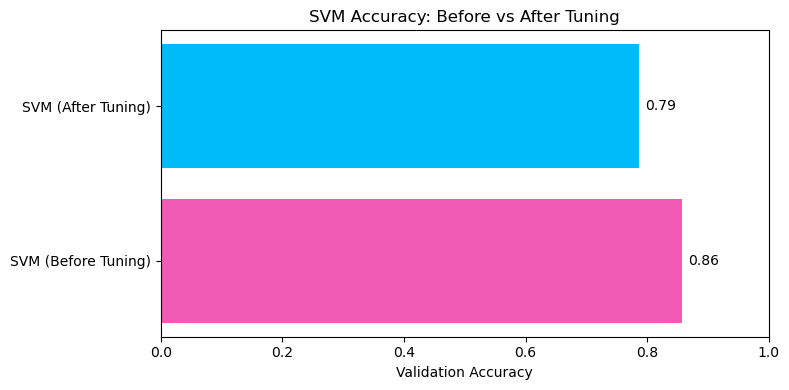

In [382]:
# Chart the before vs after
# Define accuracy values
models = ['SVM (Before Tuning)', 'SVM (After Tuning)']
accuracies = [0.8571, 0.7857]  # before and after

# Horizontal bar chart
plt.figure(figsize=(8, 4))
bars = plt.barh(models, accuracies, color=['#f15bb5', '#00bbf9'])
plt.xlabel('Validation Accuracy')
plt.title('SVM Accuracy: Before vs After Tuning')
plt.xlim(0, 1)

# Add accuracy labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}', va='center')

plt.tight_layout()
plt.show()

## Next Step: Evaluate All 3 Models on the Test Set

**RF Test**

In [368]:
# Predict on test data using the fine-tuned Randon Forest model
y_test_pred_rf = best_rf_f1.predict(X_test)  

# Calculate metrics
accuracy_rf_test = accuracy_score(y_test, y_test_pred_rf)
recall_rf_test = recall_score(y_test, y_test_pred_rf, pos_label=1)
f1_rf_test = f1_score(y_test, y_test_pred_rf, pos_label=1)
conf_matrix_rf_test = confusion_matrix(y_test, y_test_pred_rf)
report_rf_test = classification_report(y_test, y_test_pred_rf, target_names=["Healthy", "AD"])

print("Random Forest – Test Set Evaluation")
print(f"Accuracy: {round(accuracy_rf_test, 4)}")
print(f"AD Recall: {round(recall_rf_test, 4)}")
print(f"AD F1 Score: {round(f1_rf_test, 4)}")
print("\nConfusion Matrix:\n", conf_matrix_rf_test)
print("\nClassification Report:\n", report_rf_test)

Random Forest – Test Set Evaluation
Accuracy: 0.9429
AD Recall: 0.9444
AD F1 Score: 0.9444

Confusion Matrix:
 [[16  1]
 [ 1 17]]

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.94      0.94      0.94        17
          AD       0.94      0.94      0.94        18

    accuracy                           0.94        35
   macro avg       0.94      0.94      0.94        35
weighted avg       0.94      0.94      0.94        35



## Final RF Performance – Fine-Tuned Random Forest (F1 Optimized)

| Model Stage                    | Accuracy | AD Recall | AD F1 Score |
|-------------------------------|----------|-----------|-------------|
| Initial RF (Validation Set)   | 78.6%    | 78.6%     | 78.6%       |
| Fine-Tuned RF (Validation Set)| 82.1%    | 78.6%     | 81.5%       |
| Final RF (Test Set)           | 94.3%    | 94.4%     | 94.4%       |

**Interpretation:**

The fine-tuned Random Forest model demonstrated strong generalization, improving from 82.1% accuracy on the validation set to **94.3% on the test set**. The increase in AD recall and F1 score suggests the model not only avoided overfitting but became more effective at detecting Alzheimer's cases in unseen data. These consistent and high scores across metrics reinforce the model’s reliability and its potential value in clinical decision support scenarios.

**LR Test**

In [367]:
# Predict on test data using the fine-tuned Logistic Regression model
y_test_pred_lr = best_lr_f1.predict(X_test_scaled)

# Evaluate metrics
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
test_recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)
test_f1_lr = f1_score(y_test, y_test_pred_lr, pos_label=1)
confusion_matrix_lr = confusion_matrix(y_test, y_test_pred_lr)
report_lr = classification_report(y_test, y_test_pred_lr, target_names=["Healthy", "AD"])

print("Logistic Regression – Test Set Evaluation")
print(f"Accuracy: {round(test_accuracy_lr, 4)}")
print(f"AD Recall: {round(test_recall_lr, 4)}")
print(f"AD F1 Score: {round(test_f1_lr, 4)}")
print("\nConfusion Matrix:\n", confusion_matrix_lr)
print("\nClassification Report:\n", report_lr)

Logistic Regression – Test Set Evaluation
Accuracy: 0.9143
AD Recall: 0.9444
AD F1 Score: 0.9189

Confusion Matrix:
 [[15  2]
 [ 1 17]]

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.94      0.88      0.91        17
          AD       0.89      0.94      0.92        18

    accuracy                           0.91        35
   macro avg       0.92      0.91      0.91        35
weighted avg       0.92      0.91      0.91        35



## Final LR Performance – Fine-Tuned Logistic Regression (F1 Optimized)

| Model Stage                        | Accuracy | AD Recall | AD F1 Score |
|-----------------------------------|----------|-----------|-------------|
| Initial LR (Validation Set)       | 82.1%    | 71.4%     | 80.0%       |
| Fine-Tuned LR (Validation Set)    | 85.7%    | 78.6%     | 84.6%       |
| Final LR (Test Set)               | 91.4%    | 94.4%     | 91.9%       |

**Interpretation:**

After fine-tuning the Logistic Regression model with class_weight='balanced' and a regularization strength of C=0.1, performance on the validation set improved across all metrics. **Accuracy rose from 82.1% to 85.7%**, and the **F1 score increased from 80.0% to 84.6%**, reflecting a better balance between precision and recall for detecting Alzheimer’s Disease. When evaluated on the unseen test set, the fine-tuned model achieved an impressive 91.4% accuracy and a strong AD F1 score of 91.9%. With only one false negative and two false positives, the model showed excellent generalization ability, reinforcing its potential utility in real-world early screening scenarios.

**SVM Test**

In [370]:
# Predict on the test set using the fine-tuned SVM model
y_test_pred_svm = best_svm_f1.predict(X_test_scaled)

# Evaluate
svm_test_accuracy = accuracy_score(y_test, y_test_pred_svm)
svm_test_conf_matrix = confusion_matrix(y_test, y_test_pred_svm)
svm_test_report = classification_report(y_test, y_test_pred_svm, output_dict=True)
svm_test_report_df = pd.DataFrame(svm_test_report).transpose()

# Extract AD recall and F1 score (class 1 is AD)
recall_svm_test = svm_test_report["1"]["recall"]
f1_svm_test = svm_test_report["1"]["f1-score"]

print("SVM – Test Set Evaluation")
print(f"Accuracy: {round(svm_test_accuracy, 4)}")
print(f"AD Recall: {round(recall_svm_test, 4)}")
print(f"AD F1 Score: {round(f1_svm_test, 4)}")
print("\nConfusion Matrix:\n", svm_test_conf_matrix)
print("\nClassification Report:\n", svm_test_report_df)


SVM – Test Set Evaluation
Accuracy: 0.8571
AD Recall: 0.8333
AD F1 Score: 0.8571

Confusion Matrix:
 [[15  2]
 [ 3 15]]

Classification Report:
               precision    recall  f1-score    support
0              0.833333  0.882353  0.857143  17.000000
1              0.882353  0.833333  0.857143  18.000000
accuracy       0.857143  0.857143  0.857143   0.857143
macro avg      0.857843  0.857843  0.857143  35.000000
weighted avg   0.858543  0.857143  0.857143  35.000000


### Final SVM Performance Summary

| Model Stage                    | Accuracy | AD Recall | AD F1 Score |
|-------------------------------|----------|-----------|-------------|
| Initial SVM (Validation Set)  | 85.7%    | 85.7%     | 85.7%       |
| Fine-Tuned SVM (Validation Set)| 78.6%   | 71.4%     | 76.9%       |
| Final SVM (Test Set)          | 85.7%    | 83.3%     | 85.7%       |

**Interpretation:**

The Support Vector Machine (SVM) model initially performed well with balanced precision, recall, and F1 scores across both classes on the validation set. **After fine-tuning, performance slightly declined on the validation set**, with a drop in recall for the Alzheimer’s class, likely due to changes in class weight and regularization. However, when tested on unseen data, the fine-tuned model achieved consistent and balanced metrics, with an overall accuracy of **85.7%** and equal F1 scores for both classes. This suggests the model generalized well and remained stable in distinguishing between healthy individuals and those with Alzheimer's disease.

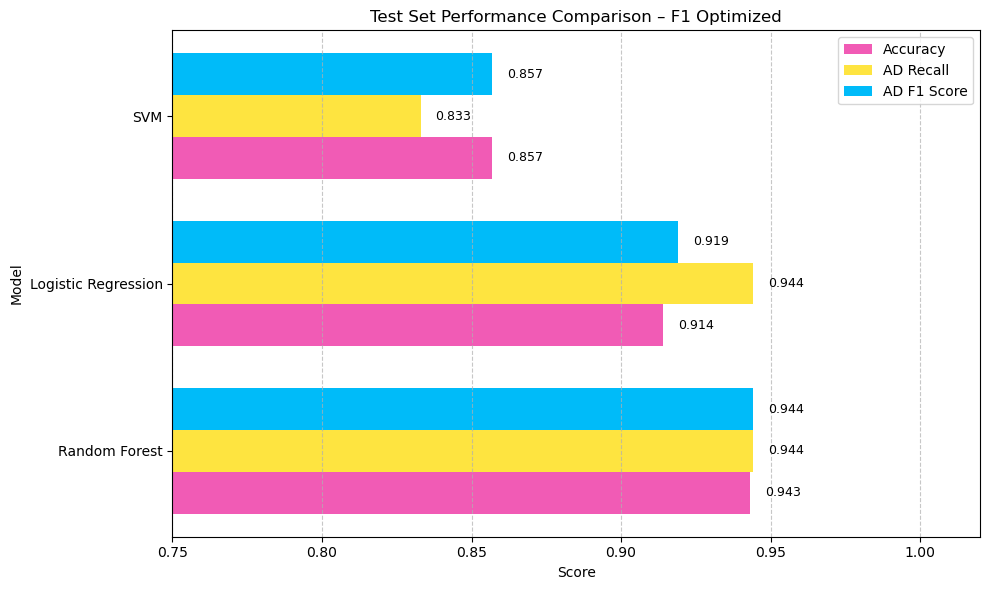

In [380]:
#Summary Chart

models = ['Random Forest', 'Logistic Regression', 'SVM']

# Metrics for each model on test set
accuracy = [0.943, 0.914, 0.857]
ad_recall = [0.944, 0.944, 0.833]
ad_f1 = [0.944, 0.919, 0.857]

bar_height = 0.25
y = np.arange(len(models))

# Horizontal bar chart
plt.figure(figsize=(10, 6))
bars1 = plt.barh(y - bar_height, accuracy, height=bar_height, color='#f15bb5', label='Accuracy')
bars2 = plt.barh(y, ad_recall, height=bar_height, color='#fee440', label='AD Recall')
bars3 = plt.barh(y + bar_height, ad_f1, height=bar_height, color='#00bbf9', label='AD F1 Score')

# Add metric labels next to each bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                 f'{width:.3f}', va='center', fontsize=9)

# Labels and title
plt.ylabel('Model')
plt.xlabel('Score')
plt.title('Test Set Performance Comparison – F1 Optimized')
plt.yticks(y, models)
plt.xlim(0.75, 1.02)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

## Test Set Performance Comparison – Chart Description

This grouped bar chart visually compares the test set performance of three fine-tuned models: Random Forest (RF), Logistic Regression (LR), and Support Vector Machine (SVM). The three evaluation metrics displayed for each model are:

Accuracy (pink)
AD Recall (yellow)
AD F1 Score (blue)

**Key Observations and Analysis:**

The chart provides a clear comparative overview of how each model performs on unseen test data, with a focus on metrics relevant to Alzheimer's Disease prediction (AD Recall and AD F1 Score), crucial for correctly identifying positive cases.

**Random Forest:**

The Random Forest model demonstrates the **strongest overall performance across all three metrics.** It achieved an Accuracy of 0.943, an AD Recall of 0.944, and an AD F1 Score of 0.944. This indicates that Random Forest is highly effective at correctly classifying both healthy and AD cases, and particularly strong at identifying actual AD patients (high recall) while maintaining a good balance between precision and recall (high F1 Score).

**Logistic Regression:**

Logistic Regression also exhibits very strong performance, closely trailing Random Forest in most categories.
It achieved an Accuracy of 0.914, an AD Recall of 0.944, and an AD F1 Score of 0.919. Also, Logistic Regression matches Random Forest in AD Recall (0.944), suggesting it is equally effective at identifying the majority of actual AD cases. Its slightly lower Accuracy and F1 Score compared to Random Forest suggest minor trade-offs in precision or overall correctness.

**SVM:**

The Support Vector Machine (SVM) model provides good results but generally scores lower than the other two models on this test set. It achieved an Accuracy of 0.857, an AD Recall of 0.833, and an AD F1 Score of 0.857. While still performing significantly better than the dummy baseline 50%, the SVM's lower AD Recall (0.833) implies it might miss a higher proportion of actual AD cases compared to Random Forest and Logistic Regression. Its F1 Score indicates a balanced performance, but at a lower overall level.

**Conclusion:**

Based on the test set evaluation, the Random Forest Classifier stands out as the most effective model for predicting Alzheimer's Disease in this context, demonstrating consistently high scores across Accuracy, AD Recall, and AD F1 Score. Logistic Regression is a very strong runner-up, particularly excelling in AD Recall. The choice of the "best" model might also depend on the specific costs associated with false positives versus false negatives in a real-world diagnostic scenario, but for overall balanced high performance, Random Forest appears to be the superior choice among those evaluated.

## Final Thoughts & Takeaways

This spin-off study directly aimed to confirm a key finding from the original DARWIN paper: that it is possible to achieve strong predictive performance in distinguishing between healthy individuals and those with Alzheimer's Disease (AD) by utilizing a carefully selected subset of cognitive tasks, specifically within the 5-15 task range.

Unlike the original authors, who explored various complex multi-classifier systems and majority voting strategies, this project took a more focused approach. I selected a subset of tasks based on their mean average and standard deviation, and then evaluated three machine learning models: Random Forest, Logistic Regression, and Support Vector Machine (SVM) against a simple baseline dummy model.

All three models demonstrated great performance on the test set, comfortably surpassing the 50% accuracy of the dummy baseline. These results confirm that, even with a concise set of just 9 tasks, it is indeed possible to achieve highly effective and clinically relevant outcomes in AD prediction. 